Processing class 'before' with 124 video directories.
Processing class 'book' with 125 video directories.
Processing class 'call' with 125 video directories.
Processing class 'chair' with 125 video directories.
Processing class 'computer' with 125 video directories.
Processing class 'doctor' with 125 video directories.
Processing class 'drink' with 125 video directories.
Processing class 'eat' with 125 video directories.
Processing class 'family' with 125 video directories.
Processing class 'food' with 125 video directories.
Processing class 'friend' with 125 video directories.
Processing class 'go' with 125 video directories.
Processing class 'help' with 125 video directories.
Processing class 'home' with 125 video directories.
Processing class 'money' with 125 video directories.
Processing class 'read' with 125 video directories.
Processing class 'sleep' with 125 video directories.
Processing class 'work' with 125 video directories.
Processing class 'write' with 125 video directories

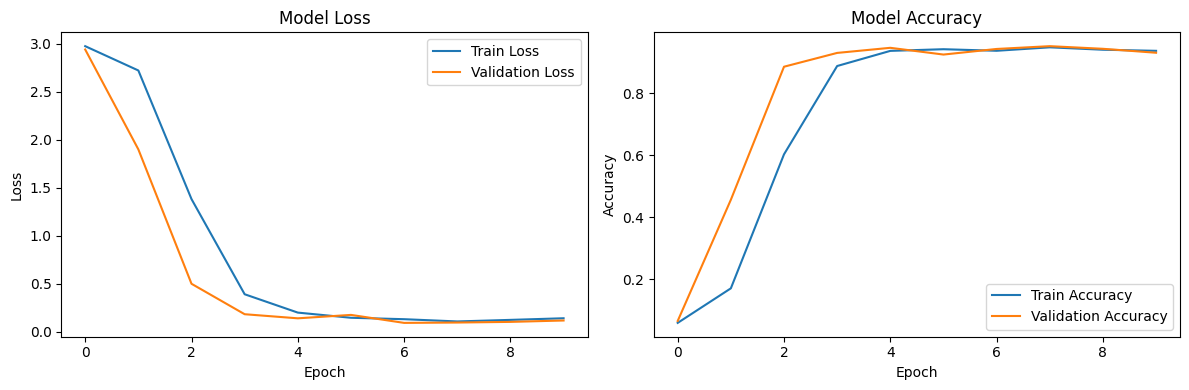

In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import matplotlib.pyplot as plt

class VideoDataGenerator(Sequence):
    def __init__(self, data_dir, target_size, batch_size=32, frames_per_clip=15, desired_classes=None):
        """
        Initialize the VideoDataGenerator.

        Args:
            data_dir: Path to the directory containing the data.
            target_size: Tuple (height, width) for resizing frames.
            batch_size: Number of samples per batch.
            frames_per_clip: Number of frames in each video clip.
            desired_classes: List of class names to include (default is None, which includes all classes).
        """
        self.data_dir = data_dir
        self.target_size = target_size
        self.batch_size = batch_size
        self.frames_per_clip = frames_per_clip

        # Filter and sort the classes as per the desired_classes
        if desired_classes:
            self.classes = sorted([cls for cls in desired_classes if cls in os.listdir(data_dir)])
        else:
            self.classes = sorted(os.listdir(data_dir))

        # Create a dictionary mapping class names to indices
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}
        
        # Load clips and labels
        self.clip_files, self.labels = self._load_clips_and_labels()

    def _load_clips_and_labels(self):
        """
        Load clip file paths and corresponding labels from the data directory.

        Returns:
            clip_files: List of clip file paths.
            labels: List of labels corresponding to the clips.
        """
        clip_files = []
        labels = []

        # Iterate through each class
        for cls in self.classes:
            class_dir = os.path.join(self.data_dir, cls)
            
            # Check if the directory exists
            if not os.path.exists(class_dir):
                print(f"Class directory '{class_dir}' does not exist.")
                continue
            
            # Iterate through each video directory within the class directory
            video_dirs = [os.path.join(class_dir, vid) for vid in os.listdir(class_dir) if os.path.isdir(os.path.join(class_dir, vid))]

            print(f"Processing class '{cls}' with {len(video_dirs)} video directories.")

            # Process each video directory
            for vid_dir in video_dirs:
                # List frames in the video directory
                frames = sorted(os.listdir(vid_dir))
                num_frames = len(frames)

                # Create clips from frames
                for i in range(0, num_frames - self.frames_per_clip + 1, self.frames_per_clip):
                    clip_files.append([os.path.join(vid_dir, frames[j]) for j in range(i, i + self.frames_per_clip)])
                    labels.append(self.class_indices[cls])

        print(f"Loaded {len(clip_files)} clips with labels.")
        return clip_files, labels

    def __len__(self):
        """
        Returns the number of batches in the dataset.
        """
        return len(self.clip_files) // self.batch_size

    def __getitem__(self, index):
        """
        Generate one batch of data.

        Args:
            index: Batch index.

        Returns:
            batch_clips: Batch of clips as a numpy array.
            batch_labels: One-hot encoded labels as a numpy array.
        """
        start_index = index * self.batch_size
        end_index = start_index + self.batch_size

        # Get the clip files and labels for the current batch
        batch_files = self.clip_files[start_index:end_index]
        batch_labels = self.labels[start_index:end_index]

        # Load clips and process them
        batch_clips = []
        for clip_files in batch_files:
            clip = [self.load_frame(frame_file) for frame_file in clip_files if self.load_frame(frame_file) is not None]
            if len(clip) == self.frames_per_clip:
                batch_clips.append(clip)

        # Convert lists to numpy arrays
        batch_clips = np.array(batch_clips)
        # Convert labels to one-hot encoded form
        batch_labels = to_categorical(batch_labels, num_classes=len(self.classes))

        return batch_clips, batch_labels

    def load_frame(self, frame_path):
        """
        Load a frame from a given path.

        Args:
            frame_path: Path to the frame.

        Returns:
            frame: Numpy array of the frame.
        """
        try:
            frame = cv2.imread(frame_path)
            if frame is None:
                raise ValueError(f"Frame is None: {frame_path}")
            frame = cv2.resize(frame, self.target_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame / 255.0  # Normalize
            return frame
        except Exception as e:
            print(f"Error loading frame: {frame_path}. Error: {e}")
            return None

# Define the parameters
target_size = (112, 112)  # Resize frames to this size
batch_size = 8
frames_per_clip = 15  # Set frames per clip to 15

# Create the data generators for training, validation, and testing sets
train_generator = VideoDataGenerator('training/', target_size, batch_size, frames_per_clip)
val_generator = VideoDataGenerator('validation/', target_size, batch_size, frames_per_clip)
test_generator = VideoDataGenerator('testing/', target_size, batch_size, frames_per_clip)

# Build the 3D CNN model
def build_3d_cnn(input_shape, num_classes):
    model = Sequential([
        Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        MaxPooling3D(pool_size=(2, 2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (frames_per_clip, target_size[0], target_size[1], 3)
num_classes = len(train_generator.classes)
model = build_3d_cnn(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('3dcnnmodel_epoch_{epoch:02d}.h5', save_freq='epoch', monitor='val_loss', save_best_only=False, mode='auto')
csv_logger = CSVLogger('training_log.csv', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
try:
    history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[checkpoint, csv_logger, reduce_lr])
except Exception as e:
    print(f"Error during training: {e}")

# Evaluate the model
try:
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')
except Exception as e:
    print(f"Error during evaluation: {e}")

# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Testing on video

In [4]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to preprocess the video
def preprocess_video(video_path, target_size, frames_per_clip):
    """
    Preprocess the video to extract frames and prepare them for the model.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the video is too short, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify a video
def classify_video(model, video_path, target_size, frames_per_clip, class_indices):
    """
    Classify a video using the trained model.

    Args:
        model: Trained 3D CNN model.
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the video.
    """
    processed_clip = preprocess_video(video_path, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    
    # Convert index to class label
    classes = list(class_indices.keys())
    predicted_class = classes[predicted_index]
    
    return predicted_class

# Example usage
if __name__ == "__main__":
    video_path = "before.mp4"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the video
    predicted_class = classify_video(model, video_path, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")


1/1 [==============================] - 2s 2s/step
Predicted Class: before


In [5]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to preprocess the video
def preprocess_video(video_path, target_size, frames_per_clip):
    """
    Preprocess the video to extract frames and prepare them for the model.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the video is too short, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify a video
def classify_video(model, video_path, target_size, frames_per_clip, class_indices):
    """
    Classify a video using the trained model.

    Args:
        model: Trained 3D CNN model.
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the video.
    """
    processed_clip = preprocess_video(video_path, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    
    # Convert index to class label
    classes = list(class_indices.keys())
    predicted_class = classes[predicted_index]
    
    return predicted_class

# Example usage
if __name__ == "__main__":
    video_path = "drink.mp4"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the video
    predicted_class = classify_video(model, video_path, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")


1/1 [==============================] - 1s 948ms/step
Predicted Class: drink


In [6]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to preprocess the video
def preprocess_video(video_path, target_size, frames_per_clip):
    """
    Preprocess the video to extract frames and prepare them for the model.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the video is too short, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify a video
def classify_video(model, video_path, target_size, frames_per_clip, class_indices):
    """
    Classify a video using the trained model.

    Args:
        model: Trained 3D CNN model.
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the video.
    """
    processed_clip = preprocess_video(video_path, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    
    # Convert index to class label
    classes = list(class_indices.keys())
    predicted_class = classes[predicted_index]
    
    return predicted_class

# Example usage
if __name__ == "__main__":
    video_path = "computer.mp4"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the video
    predicted_class = classify_video(model, video_path, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")


1/1 [==============================] - 1s 545ms/step
Predicted Class: friend


In [7]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to preprocess the video
def preprocess_video(video_path, target_size, frames_per_clip):
    """
    Preprocess the video to extract frames and prepare them for the model.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the video is too short, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify a video
def classify_video(model, video_path, target_size, frames_per_clip, class_indices):
    """
    Classify a video using the trained model.

    Args:
        model: Trained 3D CNN model.
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the video.
    """
    processed_clip = preprocess_video(video_path, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    
    # Convert index to class label
    classes = list(class_indices.keys())
    predicted_class = classes[predicted_index]
    
    return predicted_class

# Example usage
if __name__ == "__main__":
    video_path = "write.mp4"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the video
    predicted_class = classify_video(model, video_path, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")


1/1 [==============================] - 1s 555ms/step
Predicted Class: book


In [8]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to preprocess the video
def preprocess_video(video_path, target_size, frames_per_clip):
    """
    Preprocess the video to extract frames and prepare them for the model.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the video is too short, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify a video
def classify_video(model, video_path, target_size, frames_per_clip, class_indices):
    """
    Classify a video using the trained model.

    Args:
        model: Trained 3D CNN model.
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the video.
    """
    processed_clip = preprocess_video(video_path, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    
    # Convert index to class label
    classes = list(class_indices.keys())
    predicted_class = classes[predicted_index]
    
    return predicted_class

# Example usage
if __name__ == "__main__":
    video_path = "sleep.mp4"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the video
    predicted_class = classify_video(model, video_path, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")


1/1 [==============================] - 1s 630ms/step
Predicted Class: sleep


In [9]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to preprocess the video
def preprocess_video(video_path, target_size, frames_per_clip):
    """
    Preprocess the video to extract frames and prepare them for the model.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the video is too short, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify a video
def classify_video(model, video_path, target_size, frames_per_clip, class_indices):
    """
    Classify a video using the trained model.

    Args:
        model: Trained 3D CNN model.
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the video.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_video(video_path, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    video_path = "write.mp4"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the video
    predicted_class, class_probabilities = classify_video(model, video_path, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


1/1 [==============================] - 1s 913ms/step
Predicted Class: book
before: 0.00%
book: 77.15%
call: 0.05%
chair: 5.87%
computer: 0.00%
doctor: 3.05%
drink: 0.00%
eat: 0.04%
family: 0.05%
food: 0.01%
friend: 5.22%
go: 0.00%
help: 1.56%
home: 0.00%
money: 0.11%
read: 0.28%
sleep: 0.00%
work: 1.81%
write: 4.79%


In [10]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to preprocess the video
def preprocess_video(video_path, target_size, frames_per_clip):
    """
    Preprocess the video to extract frames and prepare them for the model.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the video is too short, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify a video
def classify_video(model, video_path, target_size, frames_per_clip, class_indices):
    """
    Classify a video using the trained model.

    Args:
        model: Trained 3D CNN model.
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the video.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_video(video_path, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    video_path = "sleep.mp4"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the video
    predicted_class, class_probabilities = classify_video(model, video_path, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


1/1 [==============================] - 1s 779ms/step
Predicted Class: sleep
before: 0.05%
book: 0.00%
call: 0.00%
chair: 0.00%
computer: 0.00%
doctor: 0.00%
drink: 6.52%
eat: 0.02%
family: 0.00%
food: 0.00%
friend: 0.00%
go: 0.00%
help: 0.00%
home: 0.00%
money: 0.00%
read: 0.00%
sleep: 93.41%
work: 0.00%
write: 0.00%


In [11]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to preprocess the video
def preprocess_video(video_path, target_size, frames_per_clip):
    """
    Preprocess the video to extract frames and prepare them for the model.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the video is too short, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify a video
def classify_video(model, video_path, target_size, frames_per_clip, class_indices):
    """
    Classify a video using the trained model.

    Args:
        model: Trained 3D CNN model.
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the video.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_video(video_path, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    video_path = "drink.mp4"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the video
    predicted_class, class_probabilities = classify_video(model, video_path, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


1/1 [==============================] - 0s 495ms/step
Predicted Class: drink
before: 0.23%
book: 0.20%
call: 1.29%
chair: 0.06%
computer: 0.14%
doctor: 0.02%
drink: 35.81%
eat: 34.62%
family: 0.20%
food: 25.04%
friend: 0.55%
go: 0.15%
help: 0.22%
home: 0.05%
money: 0.00%
read: 0.00%
sleep: 0.04%
work: 1.18%
write: 0.20%


In [12]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to preprocess the video
def preprocess_video(video_path, target_size, frames_per_clip):
    """
    Preprocess the video to extract frames and prepare them for the model.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the video is too short, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify a video
def classify_video(model, video_path, target_size, frames_per_clip, class_indices):
    """
    Classify a video using the trained model.

    Args:
        model: Trained 3D CNN model.
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the video.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_video(video_path, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    video_path = "computer.mp4"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the video
    predicted_class, class_probabilities = classify_video(model, video_path, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


1/1 [==============================] - 1s 688ms/step
Predicted Class: friend
before: 2.13%
book: 8.25%
call: 4.47%
chair: 2.66%
computer: 0.91%
doctor: 1.85%
drink: 3.43%
eat: 13.54%
family: 3.27%
food: 12.18%
friend: 33.13%
go: 0.96%
help: 2.38%
home: 4.43%
money: 0.45%
read: 0.96%
sleep: 0.34%
work: 3.49%
write: 1.18%


In [13]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to preprocess the video
def preprocess_video(video_path, target_size, frames_per_clip):
    """
    Preprocess the video to extract frames and prepare them for the model.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the video is too short, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify a video
def classify_video(model, video_path, target_size, frames_per_clip, class_indices):
    """
    Classify a video using the trained model.

    Args:
        model: Trained 3D CNN model.
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the video.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_video(video_path, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    video_path = "before.mp4"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the video
    predicted_class, class_probabilities = classify_video(model, video_path, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


1/1 [==============================] - 1s 798ms/step
Predicted Class: before
before: 34.12%
book: 0.17%
call: 0.53%
chair: 1.12%
computer: 0.53%
doctor: 1.97%
drink: 11.46%
eat: 24.19%
family: 2.30%
food: 2.59%
friend: 0.06%
go: 0.62%
help: 1.53%
home: 1.92%
money: 5.30%
read: 0.73%
sleep: 1.13%
work: 7.17%
write: 2.55%


Testing on the test folder

In [17]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to load and preprocess frames from a directory
def preprocess_frames(frame_dir, target_size, frames_per_clip):
    """
    Preprocess frames from a directory to prepare them for the model.

    Args:
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    frame_files = sorted(os.listdir(frame_dir))
    frames = []

    for frame_file in frame_files:
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the directory has too few frames, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify frames in a directory
def classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices):
    """
    Classify frames from a directory using the trained model.

    Args:
        model: Trained 3D CNN model.
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the frames.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_frames(frame_dir, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    frame_dir = "testing/before/05731"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the frames in the specified directory
    print(f"Classifying frames in directory: {frame_dir}")
    predicted_class, class_probabilities = classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


Classifying frames in directory: testing/before/05731
1/1 [==============================] - 0s 451ms/step
Predicted Class: before
before: 100.00%
book: 0.00%
call: 0.00%
chair: 0.00%
computer: 0.00%
doctor: 0.00%
drink: 0.00%
eat: 0.00%
family: 0.00%
food: 0.00%
friend: 0.00%
go: 0.00%
help: 0.00%
home: 0.00%
money: 0.00%
read: 0.00%
sleep: 0.00%
work: 0.00%
write: 0.00%


In [18]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to load and preprocess frames from a directory
def preprocess_frames(frame_dir, target_size, frames_per_clip):
    """
    Preprocess frames from a directory to prepare them for the model.

    Args:
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    frame_files = sorted(os.listdir(frame_dir))
    frames = []

    for frame_file in frame_files:
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the directory has too few frames, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify frames in a directory
def classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices):
    """
    Classify frames from a directory using the trained model.

    Args:
        model: Trained 3D CNN model.
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the frames.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_frames(frame_dir, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    frame_dir = "testing/friend/23572"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the frames in the specified directory
    print(f"Classifying frames in directory: {frame_dir}")
    predicted_class, class_probabilities = classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


Classifying frames in directory: testing/friend/23572
1/1 [==============================] - 1s 597ms/step
Predicted Class: friend
before: 0.00%
book: 0.00%
call: 0.00%
chair: 0.00%
computer: 0.00%
doctor: 0.00%
drink: 0.00%
eat: 0.00%
family: 0.00%
food: 0.00%
friend: 100.00%
go: 0.00%
help: 0.00%
home: 0.00%
money: 0.00%
read: 0.00%
sleep: 0.00%
work: 0.00%
write: 0.00%


In [20]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to load and preprocess frames from a directory
def preprocess_frames(frame_dir, target_size, frames_per_clip):
    """
    Preprocess frames from a directory to prepare them for the model.

    Args:
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    frame_files = sorted(os.listdir(frame_dir))
    frames = []

    for frame_file in frame_files:
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the directory has too few frames, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify frames in a directory
def classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices):
    """
    Classify frames from a directory using the trained model.

    Args:
        model: Trained 3D CNN model.
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the frames.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_frames(frame_dir, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    frame_dir = "testing/read/46268 - Copy"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the frames in the specified directory
    print(f"Classifying frames in directory: {frame_dir}")
    predicted_class, class_probabilities = classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


Classifying frames in directory: testing/read/46268 - Copy
1/1 [==============================] - 1s 624ms/step
Predicted Class: read
before: 0.00%
book: 0.00%
call: 0.00%
chair: 0.00%
computer: 0.00%
doctor: 0.00%
drink: 0.00%
eat: 0.00%
family: 0.00%
food: 0.00%
friend: 0.00%
go: 0.00%
help: 0.00%
home: 0.00%
money: 0.00%
read: 100.00%
sleep: 0.00%
work: 0.00%
write: 0.00%


In [25]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to load and preprocess frames from a directory
def preprocess_frames(frame_dir, target_size, frames_per_clip):
    """
    Preprocess frames from a directory to prepare them for the model.

    Args:
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    frame_files = sorted(os.listdir(frame_dir))
    frames = []

    for frame_file in frame_files:
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the directory has too few frames, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify frames in a directory
def classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices):
    """
    Classify frames from a directory using the trained model.

    Args:
        model: Trained 3D CNN model.
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the frames.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_frames(frame_dir, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    frame_dir = "testing/family/69316 - Copy"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the frames in the specified directory
    print(f"Classifying frames in directory: {frame_dir}")
    predicted_class, class_probabilities = classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


Classifying frames in directory: testing/family/69316 - Copy
1/1 [==============================] - 1s 1s/step
Predicted Class: food
before: 0.01%
book: 0.00%
call: 0.00%
chair: 0.02%
computer: 0.02%
doctor: 0.01%
drink: 0.00%
eat: 0.01%
family: 34.86%
food: 64.97%
friend: 0.01%
go: 0.04%
help: 0.00%
home: 0.00%
money: 0.00%
read: 0.00%
sleep: 0.00%
work: 0.00%
write: 0.04%


In [26]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to load and preprocess frames from a directory
def preprocess_frames(frame_dir, target_size, frames_per_clip):
    """
    Preprocess frames from a directory to prepare them for the model.

    Args:
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    frame_files = sorted(os.listdir(frame_dir))
    frames = []

    for frame_file in frame_files:
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the directory has too few frames, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify frames in a directory
def classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices):
    """
    Classify frames from a directory using the trained model.

    Args:
        model: Trained 3D CNN model.
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the frames.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_frames(frame_dir, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    frame_dir = "testing/friend/23572"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the frames in the specified directory
    print(f"Classifying frames in directory: {frame_dir}")
    predicted_class, class_probabilities = classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


Classifying frames in directory: testing/friend/23572
1/1 [==============================] - 1s 512ms/step
Predicted Class: friend
before: 0.00%
book: 0.00%
call: 0.00%
chair: 0.00%
computer: 0.00%
doctor: 0.00%
drink: 0.00%
eat: 0.00%
family: 0.00%
food: 0.00%
friend: 100.00%
go: 0.00%
help: 0.00%
home: 0.00%
money: 0.00%
read: 0.00%
sleep: 0.00%
work: 0.00%
write: 0.00%


In [27]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to load and preprocess frames from a directory
def preprocess_frames(frame_dir, target_size, frames_per_clip):
    """
    Preprocess frames from a directory to prepare them for the model.

    Args:
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    frame_files = sorted(os.listdir(frame_dir))
    frames = []

    for frame_file in frame_files:
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the directory has too few frames, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify frames in a directory
def classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices):
    """
    Classify frames from a directory using the trained model.

    Args:
        model: Trained 3D CNN model.
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the frames.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_frames(frame_dir, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    frame_dir = "testing/go/24961"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the frames in the specified directory
    print(f"Classifying frames in directory: {frame_dir}")
    predicted_class, class_probabilities = classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


Classifying frames in directory: testing/go/24961
1/1 [==============================] - 1s 528ms/step
Predicted Class: go
before: 0.00%
book: 0.00%
call: 0.00%
chair: 0.00%
computer: 0.00%
doctor: 0.00%
drink: 0.16%
eat: 0.00%
family: 0.00%
food: 0.00%
friend: 0.00%
go: 99.83%
help: 0.00%
home: 0.00%
money: 0.00%
read: 0.00%
sleep: 0.00%
work: 0.00%
write: 0.00%


In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to load and preprocess frames from a directory
def preprocess_frames(frame_dir, target_size, frames_per_clip):
    """
    Preprocess frames from a directory to prepare them for the model.

    Args:
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    frame_files = sorted(os.listdir(frame_dir))
    frames = []

    for frame_file in frame_files:
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the directory has too few frames, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify frames in a directory
def classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices):
    """
    Classify frames from a directory using the trained model.

    Args:
        model: Trained 3D CNN model.
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the frames.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_frames(frame_dir, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    frame_dir = "testing/money/36654"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = train_generator.class_indices  # Assuming the same class_indices used during training

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the frames in the specified directory
    print(f"Classifying frames in directory: {video_frames}")
    predicted_class, class_probabilities = classify_frames(model, video_frames, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


NameError: name 'train_generator' is not defined

video - testing Again

In [8]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to preprocess frames from a video
def preprocess_video(video_path, target_size, frames_per_clip):
    """
    Preprocess frames from a video to prepare them for the model.

    Args:
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    
    cap.release()

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the video is too short, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify frames in a video
def classify_video(model, video_path, target_size, frames_per_clip, class_indices):
    """
    Classify frames from a video using the trained model.

    Args:
        model: Trained 3D CNN model.
        video_path: Path to the video file.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the frames.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_video(video_path, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    video_path = "before.mp4"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = {
        "before": 0,
        "book": 1,
        "call": 2,
        "chair": 3,
        "computer": 4,
        "doctor": 5,
        "drink": 6,
        "eat": 7,
        "family": 8,
        "food": 9,
        "friend": 10,
        "go": 11,
        "help": 12,
        "home": 13,
        "money": 14,
        "read": 15,
        "sleep": 16,
        "work": 17,
        "write": 18
    }

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Classify the frames in the specified video
    print(f"Classifying frames from video: {video_path}")
    predicted_class, class_probabilities = classify_video(model, video_path, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


Classifying frames from video: before.mp4
1/1 [==============================] - 0s 308ms/step
Predicted Class: before
before: 34.12%
book: 0.17%
call: 0.53%
chair: 1.12%
computer: 0.53%
doctor: 1.97%
drink: 11.46%
eat: 24.19%
family: 2.30%
food: 2.59%
friend: 0.06%
go: 0.62%
help: 1.53%
home: 1.92%
money: 5.30%
read: 0.73%
sleep: 1.13%
work: 7.17%
write: 2.55%


In [15]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

# Function to save video frames to a directory
def save_video_frames(video_path, frame_dir, frames_per_clip):
    """
    Save video frames to a directory.

    Args:
        video_path: Path to the video file.
        frame_dir: Path to the directory to save frames.
        frames_per_clip: Number of frames to extract per clip.
    """
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    
    if not os.path.exists(frame_dir):
        os.makedirs(frame_dir)
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(frame_dir, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_path, frame)
        frame_count += 1
        if frame_count == frames_per_clip:
            break
    
    cap.release()

# Function to preprocess frames from a directory
def preprocess_frames(frame_dir, target_size, frames_per_clip):
    """
    Preprocess frames from a directory to prepare them for the model.

    Args:
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.

    Returns:
        processed_clip: Numpy array of the processed video clip.
    """
    frame_files = sorted(os.listdir(frame_dir))
    frames = []

    for frame_file in frame_files:
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    # Select the first `frames_per_clip` frames
    if len(frames) >= frames_per_clip:
        processed_clip = np.array(frames[:frames_per_clip])
    else:
        # If the directory has too few frames, repeat frames to fit the required length
        processed_clip = np.array(frames * (frames_per_clip // len(frames) + 1))[:frames_per_clip]

    return processed_clip

# Function to classify frames in a directory
def classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices):
    """
    Classify frames from a directory using the trained model.

    Args:
        model: Trained 3D CNN model.
        frame_dir: Path to the directory containing the frames.
        target_size: Tuple (height, width) for resizing frames.
        frames_per_clip: Number of frames in each video clip.
        class_indices: Dictionary mapping class names to indices.

    Returns:
        predicted_class: The predicted class label for the frames.
        class_probabilities: Dictionary with class labels and their corresponding probabilities.
    """
    processed_clip = preprocess_frames(frame_dir, target_size, frames_per_clip)
    processed_clip = np.expand_dims(processed_clip, axis=0)  # Add batch dimension

    # Perform inference
    predictions = model.predict(processed_clip)
    predicted_index = np.argmax(predictions)
    predicted_class = list(class_indices.keys())[predicted_index]
    
    # Get probabilities for each class
    class_probabilities = {class_name: prob for class_name, prob in zip(class_indices.keys(), predictions[0])}
    
    return predicted_class, class_probabilities

# Example usage
if __name__ == "__main__":
    video_path = "drink.mp4"
    frame_dir = "video_frames"
    target_size = (112, 112)
    frames_per_clip = 15
    class_indices = {
        "before": 0,
        "book": 1,
        "call": 2,
        "chair": 3,
        "computer": 4,
        "doctor": 5,
        "drink": 6,
        "eat": 7,
        "family": 8,
        "food": 9,
        "friend": 10,
        "go": 11,
        "help": 12,
        "home": 13,
        "money": 14,
        "read": 15,
        "sleep": 16,
        "work": 17,
        "write": 18
    }

    # Load the trained model
    model = load_model('3dcnnmodel_epoch_07.h5')

    # Save video frames to a directory
    save_video_frames(video_path, frame_dir, frames_per_clip)

    # Classify the frames in the specified directory
    print(f"Classifying frames in directory: {frame_dir}")
    predicted_class, class_probabilities = classify_frames(model, frame_dir, target_size, frames_per_clip, class_indices)
    print(f"Predicted Class: {predicted_class}")

    # Print the probabilities for each class
    for class_name, prob in class_probabilities.items():
        print(f"{class_name}: {prob * 100:.2f}%")


Classifying frames in directory: video_frames
1/1 [==============================] - 0s 452ms/step
Predicted Class: eat
before: 0.20%
book: 0.16%
call: 1.09%
chair: 0.05%
computer: 0.13%
doctor: 0.01%
drink: 35.12%
eat: 35.75%
family: 0.19%
food: 25.25%
friend: 0.43%
go: 0.13%
help: 0.20%
home: 0.04%
money: 0.00%
read: 0.00%
sleep: 0.04%
work: 1.04%
write: 0.17%


office 